<a href="https://colab.research.google.com/github/GayatriNagaSoujanya/Diabetic-Retinopathy/blob/main/MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install opendatasets

In [ ]:
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/competitions/aptos2019-blindness-detection/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: miniprojectiv
Your Kaggle Key: ··········


100%|██████████| 9.51G/9.51G [01:45<00:00, 97.0MB/s]



Extracting archive ./aptos2019-blindness-detection/aptos2019-blindness-detection.zip to ./aptos2019-blindness-detection


In [ ]:
!mv /content/aptos2019-blindness-detection /content/drive/My\ Drive/


mv: inter-device move failed: '/content/aptos2019-blindness-detection' to '/content/drive/My Drive/aptos2019-blindness-detection'; unable to remove target: Directory not empty


In [ ]:
# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


In [ ]:
def load_data():
    train_csv_path = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test_csv_path = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train = pd.read_csv(train_csv_path)
    test = pd.read_csv(test_csv_path)

    train_dir = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/train_images')
    test_dir = os.path.join('/content/drive/MyDrive/aptos2019-blindness-detection/test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [ ]:
train,test =load_data()
print(train.shape,test.shape,'\n')
train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                                          file_path  \
0  000c1434d8d7         2  /content/drive/MyDrive/aptos2019-blindness-det...   
1  001639a390f0         4  /content/drive/MyDrive/aptos2019-blindness-det...   
2  0024cdab0c1e         1  /content/drive/MyDrive/aptos2019-blindness-det...   
3  002c21358ce6         0  /content/drive/MyDrive/aptos2019-blindness-det...   
4  005b95c28852         0  /content/drive/MyDrive/aptos2019-blindness-det...   
5  0083ee8054ee         4  /content/drive/MyDrive/aptos2019-blindness-det...   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png

In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()

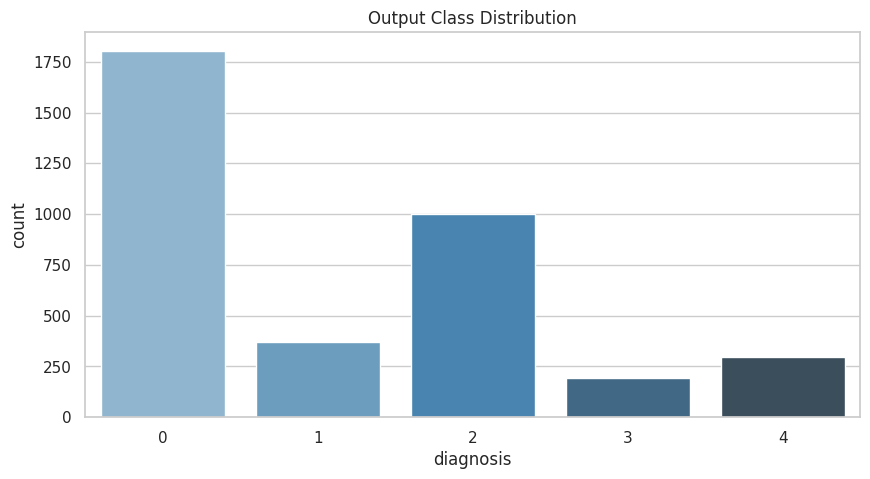

In [ ]:
plot_classes(train)

In [ ]:
# Defining a global variable to be used as Image size..
IMG_SIZE = 200

In [ ]:
'''This Function converts a color image to gray scale image'''

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img


'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class)
'''

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

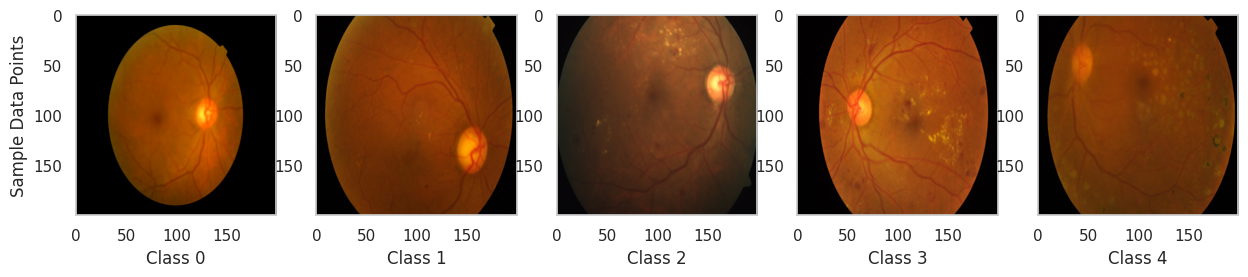

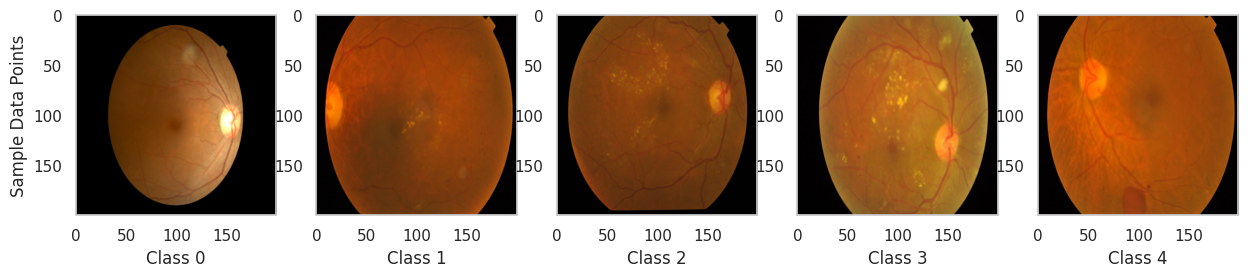

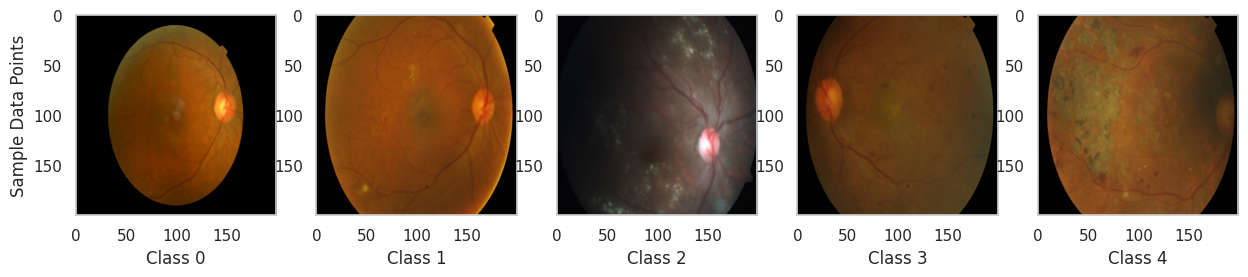

In [ ]:
visualize_imgs(train,3,color_scale = None)

In [ ]:
import os

file_path = "/content/drive/MyDrive/aptos2019-blindness-detection/train_images/7a42443ed106.png"

if os.path.isfile(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


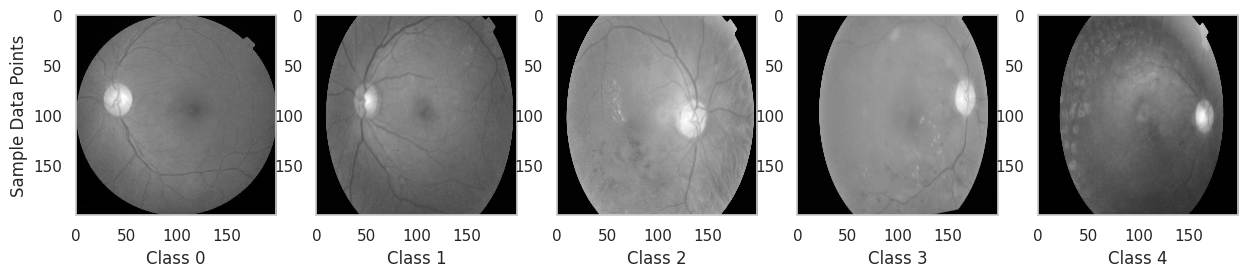

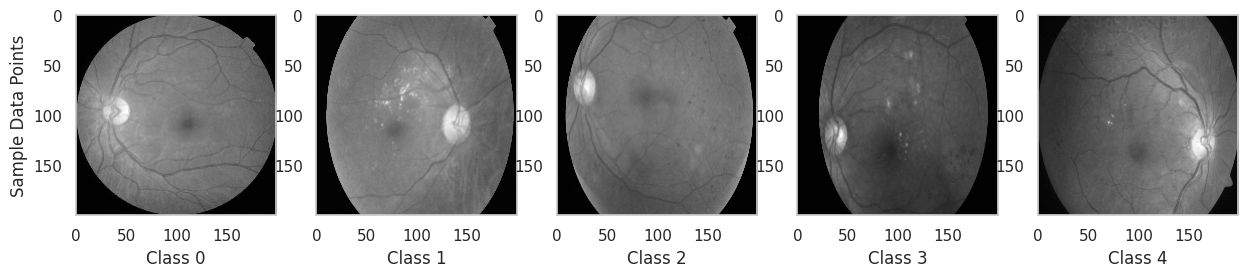

In [ ]:
visualize_imgs(train,2,color_scale = 'gray')

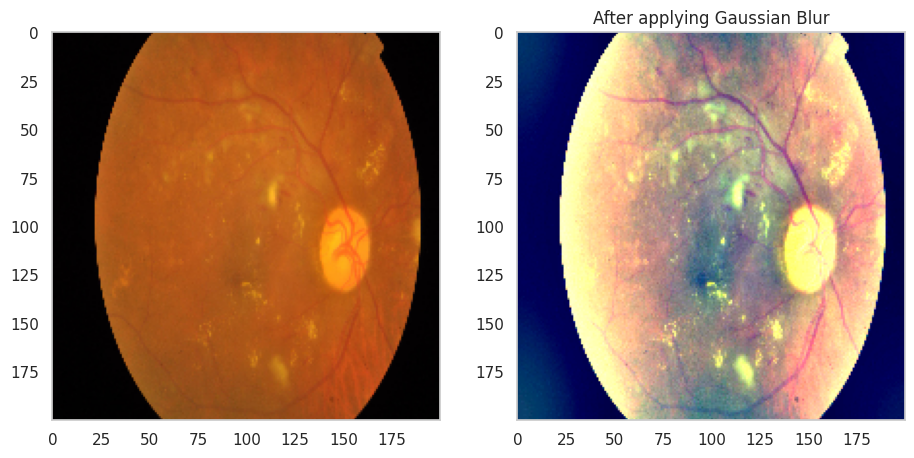

In [ ]:
'''
This section of code applies gaussian blur on top of image
'''

rn = np.random.randint(low = 0,high = len(train) - 1)

img = cv2.imread(train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

In [ ]:
'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img


def circle_crop(img, sigmaX):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

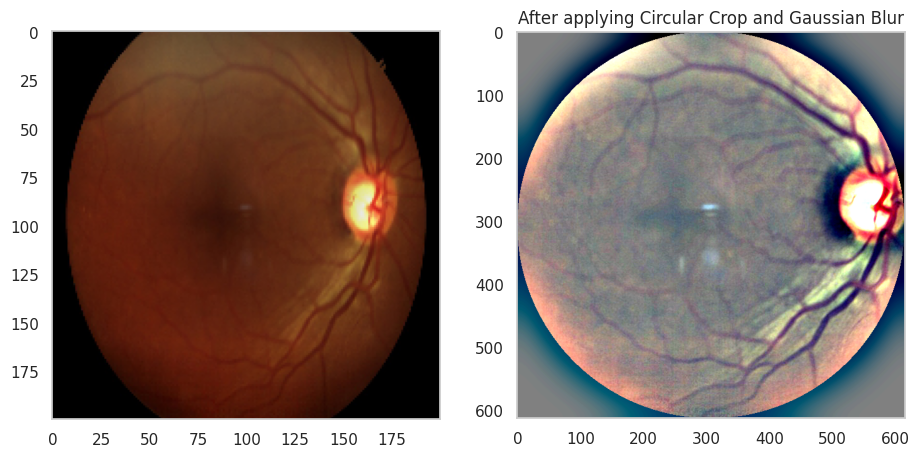

In [ ]:
'''Perform Image Processing on a sample image'''

rn = np.random.randint(low = 0,high = len(train) - 1)

#img = img_t
img = cv2.imread(train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()


In [ ]:
# ref - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class)
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

In [ ]:
visualize_img_process(train,5,sigmaX = 30)

In [ ]:
'''
The code below applies TSNE on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE
'''

'\nThe code below applies TSNE on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE\n'

In [ ]:
# ref - https://www.kaggle.com/code1110/are-there-clusters-pca-tsne-vae

In [ ]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((train.shape[0], npix, npix))
for i in tqdm_notebook(range(train.shape[0])):
    # load an image
    img = cv2.imread(train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_train[i, :, :] = cv2.resize(img, (npix, npix))

print("X_train shape: " + str(np.shape(X_train)))

  0%|          | 0/3662 [00:00<?, ?it/s]

X_train shape: (3662, 224, 224)


In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = train['diagnosis']

  0%|          | 0/8 [00:00<?, ?it/s]

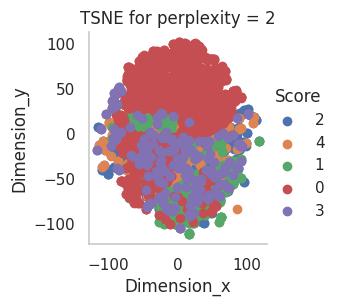

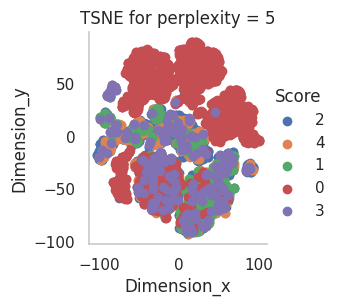

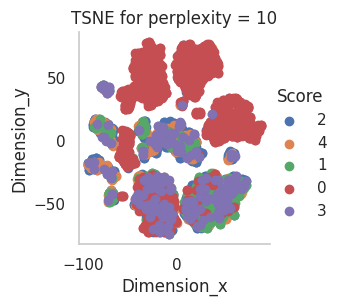

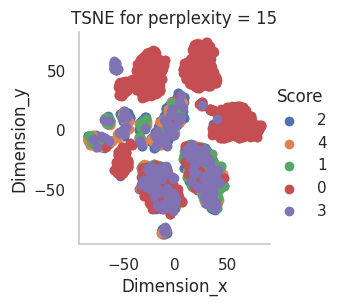

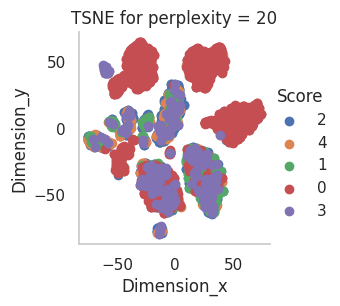

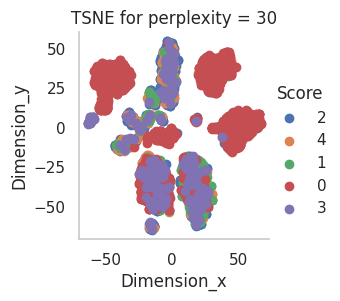

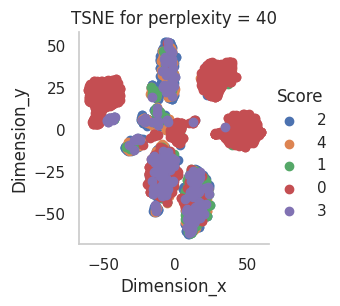

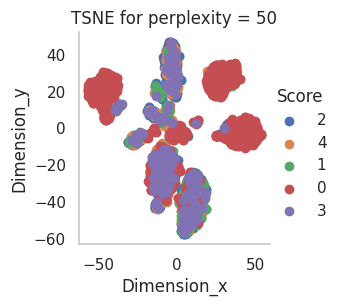

In [ ]:
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values

    sns.FacetGrid(df_tsne, hue='Score').map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

In [ ]:
# ref - https://www.youtube.com/watch?v=hxLU32zhze0
# ref - https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
# ref - https://keras.io/preprocessing/image/

'''This Function generates 'lim' number of Image Augmentations from a random Image in the directory'''

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(train.file_path.iloc[np.random.randint(low = 0,high = len(train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()

    img_arr = img.reshape((1,) + img.shape)

    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

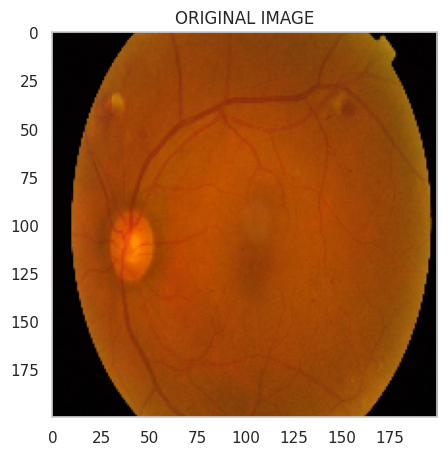

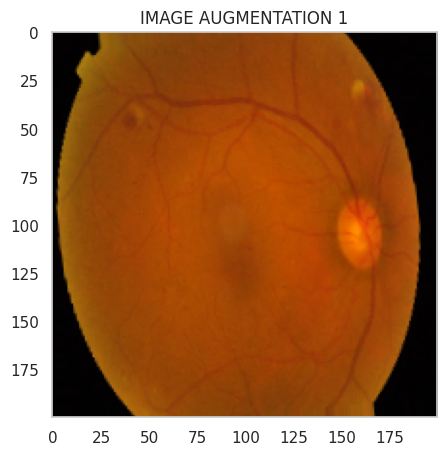

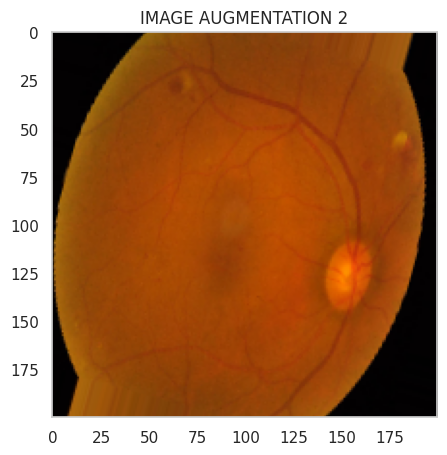

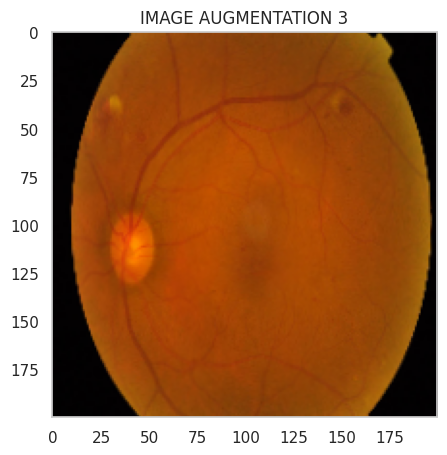

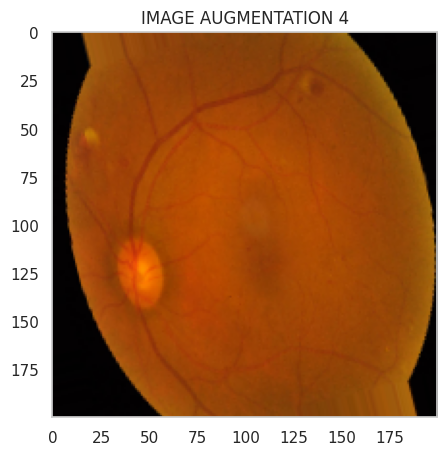

In [ ]:
generate_augmentations(4)

In [ ]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import multiprocessing
from multiprocessing.pool import ThreadPool
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False


# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


In [ ]:
'''
This function reads data from the respective train and test directories
'''

def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = os.path.join('./','/content/drive/MyDrive/aptos2019-blindness-detection/train_images/')
    test_dir = os.path.join('./','/content/drive/MyDrive/aptos2019-blindness-detection/test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

In [ ]:
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = os.path.join('./','/content/drive/MyDrive/aptos2019-blindness-detection/train_images/')
    test_dir = os.path.join('./','/content/drive/MyDrive/aptos2019-blindness-detection/test_images/')

In [ ]:
# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory to the correct location
os.chdir('/content/drive/MyDrive/aptos2019-blindness-detection')

# Load the data
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train,test

train,test = load_data()
print(train.shape,test.shape,'\n')
train.head(6)

Mounted at /content/drive
(3662, 4) (1928, 3) 



id_code diagnosis                        file_path         file_name
0  000c1434d8d7         2  ./train_images/000c1434d8d7.png  000c1434d8d7.png
1  001639a390f0         4  ./train_images/001639a390f0.png  001639a390f0.png
2  0024cdab0c1e         1  ./train_images/0024cdab0c1e.png  0024cdab0c1e.png
3  002c21358ce6         0  ./train_images/002c21358ce6.png  002c21358ce6.png
4  005b95c28852         0  ./train_images/005b95c28852.png  005b95c28852.png
5  0083ee8054ee         4  ./train_images/0083ee8054ee.png  0083ee8054ee.png

In [ ]:
train_train,train_valid = train_test_split(train,test_size = 0.2)
print(train_train.shape,train_valid.shape)

(2929, 4) (733, 4)


In [ ]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show()

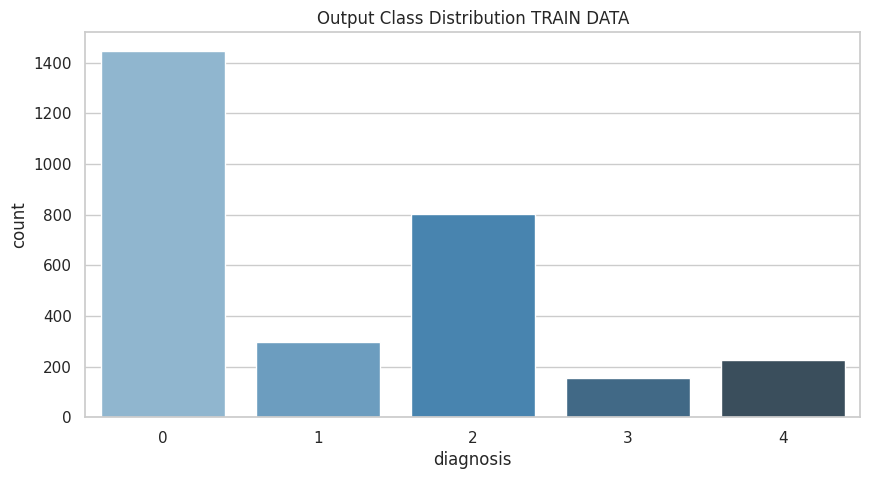

In [ ]:
plot_classes(train_train,"TRAIN DATA")

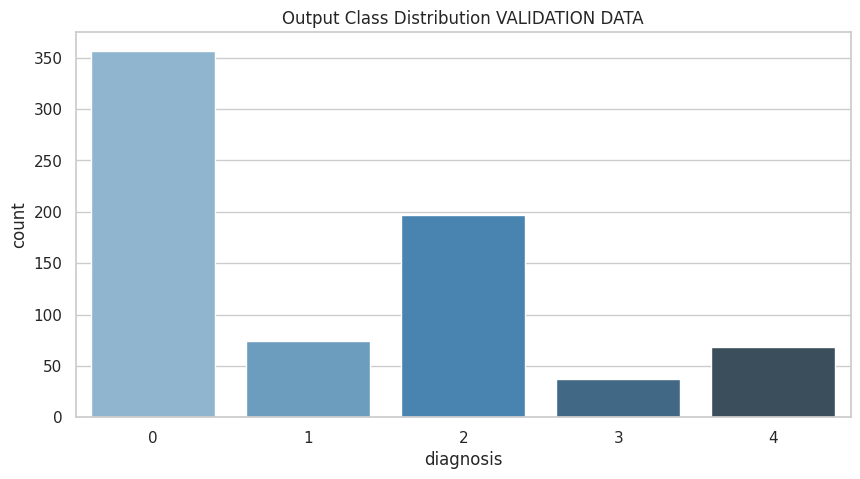

In [ ]:
plot_classes(train_valid,'VALIDATION DATA')

In [ ]:

file = open('train_train', 'wb')
pickle.dump(train_train, file)
file.close()

file = open('train_valid', 'wb')
pickle.dump(train_valid, file)
file.close()


In [ ]:
# Check if the file exists in the current working directory
import os

if not os.path.exists('train_train'):
    raise FileNotFoundError("File 'train_train' not found in the current working directory.")

# Open the file in read binary mode
file = open('train_train', 'rb')

# Load the pickled data
train_train = pickle.load(file)

# Close the file
file.close()

# Repeat the same process for 'df_train_test'
if not os.path.exists('train_valid'):
    raise FileNotFoundError("File 'train_valid' not found in the current working directory.")

file = open('train_valid', 'rb')
train_valid = pickle.load(file)
file.close()

In [ ]:
file = open('train_train', 'wb')
pickle.dump(train_train, file)
file.close()

In [ ]:
import os

if not os.path.exists('train_train'):
    raise FileNotFoundError("File 'train_train' not found in the current working directory.")

In [ ]:
file = open('train_valid', 'wb')
pickle.dump(train_valid, file)
file.close()

In [ ]:
import os

# Create the directory if it does not exist
if not os.path.exists('./train_images_resized_preprocessed'):
    os.makedirs('./train_images_resized_preprocessed')

In [ ]:
# Check if the file is a directory
if not os.path.isdir('./train_images_resized_preprocessed'):
    raise NotADirectoryError("File 'train_train' is not a directory.")

In [ ]:
# Check if the user has permission to access the directory or file
if not os.access('./train_images_resized_preprocessed/train_train', os.R_OK):
    raise PermissionError("User does not have permission to access the directory or file.")

In [ ]:
import os

# Create the directory if it does not exist
if not os.path.exists('./test_images_resized_preprocessed'):
    os.makedirs('./test_images_resized_preprocessed')

In [ ]:
# Check if the file is a directory
if not os.path.isdir('./test_images_resized_preprocessed'):
    raise NotADirectoryError("File 'train_valid' is not a directory.")

In [ ]:
# Check if the user has permission to access the directory or file
if not os.access('./test_images_resized_preprocessed', os.R_OK):
    raise PermissionError("User does not have permission to access the directory or file.")

In [ ]:
print(train_train.shape,train_valid.shape)
print(len(os.listdir('./train_images_resized_preprocessed')),len(os.listdir('./test_images_resized_preprocessed')))

(2929, 4) (733, 4)
2 0


In [ ]:
IMG_SIZE  = 512

In [ ]:
'''Function loads an image from Folder , Resizes and saves in another directory '''

def image_resize_save(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','valid_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
#image_resize_save(train.id_code.iloc[201])

In [ ]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results

In [ ]:
# Use 6 cores
multiprocess_image_downloader(6, list(train_valid.id_code.values))

MESSAGE: Running 6 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

def preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','test_images_resized_preprocessed','{}.png'.format(file))

    img = cv2.imread(input_filepath)
    img = circle_crop(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [ ]:
def preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','test_images_resized_preprocessed','{}.png'.format(file))

    img = cv2.imread(input_filepath)
    if img is None:
        print(f"Error reading image: {input_filepath}")
        return  # Skip processing this image

    img = circle_crop(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    if not os.path.isfile(input_filepath):
        print(f"File not found: {input_filepath}")
        return  # Skip processing this image

    img = cv2.imread(input_filepath)
    if img is None:
        print(f"Error reading image: {input_filepath}")
        return  # Skip processing this image

    img = circle_crop(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
def preprocess_image(file):
    input_filepath = os.path.join('./','test_images_resized','{}.png'.format(file))
    if not os.path.isfile(input_filepath):
        print(f"File not found: {input_filepath}")
        return  # Skip processing this image

    img = cv2.imread(input_filepath)
    if img is None:
        print(f"Error reading file")

In [ ]:
# Use 6 cores
multiprocess_image_processor(6, list(train_valid.id_code.values))

MESSAGE: Running 6 process
File not found: ./test_images_resized/e4151feb8443.png
File not found: ./test_images_resized/1c6d119c3d70.png
File not found: ./test_images_resized/60f15dd68d30.png
File not found: ./test_images_resized/f549294e12e1.png
File not found: ./test_images_resized/3730c322d35b.png
File not found: ./test_images_resized/1541226c5d72.png
File not found: ./test_images_resized/a15590a7d774.png
File not found: ./test_images_resized/51a1d162e223.png
File not found: ./test_images_resized/d2fb715b0c41.png
File not found: ./test_images_resized/9782c0489eca.png
File not found: ./test_images_resized/d2c2f02bb313.png
File not found: ./test_images_resized/7ed4128b2a4e.png
File not found: ./test_images_resized/8ef2eb8c51c4.png
File not found: ./test_images_resized/dea7538bb91a.png
File not found: ./test_images_resized/58af2c054ced.png
File not found: ./test_images_resized/54dc6e8107cd.png
File not found: ./test_images_resized/3b9817a39adf.png
File not found: ./test_images_resized/

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

2  CPU cores


In [ ]:
!pip install google-auth

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def load_data():
    # Use absolute path to the file
    file = open("/content/gdrive/MyDrive/aptos2019-blindness-detection/train_train", 'rb')
    train_train = pickle.load(file)
    file.close()

    file = open("/content/gdrive/MyDrive/aptos2019-blindness-detection/train_valid", 'rb')
    train_valid = pickle.load(file)
    file.close()

    return train_train, train_valid

train_train, train_valid = load_data()
print(train_train.shape, train_valid.shape, '\n')
train_train.head(6)

(2929, 4) (733, 4) 



id_code diagnosis                        file_path  \
2181  996f9bba4ef0         0  ./train_images/996f9bba4ef0.png   
33    025a169a0bb0         2  ./train_images/025a169a0bb0.png   
2225  9c514d2d5b3f         0  ./train_images/9c514d2d5b3f.png   
451   1fb455685328         0  ./train_images/1fb455685328.png   
1431  64b9206afb3f         0  ./train_images/64b9206afb3f.png   
663   2f4e81787d9b         1  ./train_images/2f4e81787d9b.png   

             file_name  
2181  996f9bba4ef0.png  
33    025a169a0bb0.png  
2225  9c514d2d5b3f.png  
451   1fb455685328.png  
1431  64b9206afb3f.png  
663   2f4e81787d9b.png

In [ ]:
IMG_SIZE = 512

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):
    """
    Create circular crop around image centre
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))

    img = cv2.imread(input_filepath)
    img = circle_crop(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


In [ ]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [ ]:
# Use 2 cores (colab)
# ref - https://stackoverflow.com/questions/1006289/how-to-find-out-the-number-of-cpus-using-python

#multiprocess_image_processor(2, list(train_train.id_code.values))

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)

    train_generator=train_datagen.flow_from_dataframe(dataframe=train_train,
                                                      directory="/content/gdrive/MyDrive/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=train_train,
                                                      directory="/content/gdrive/MyDrive/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=train_valid,
                                                      directory = "/content/gdrive/MyDrive/aptos2019-blindness-detection/train_images",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)

    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(train_train,train_valid)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
    base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [ ]:
file_path = "/content/gdrive/MyDrive/aptos2019-blindness-detection/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
if not os.path.exists(file_path):
    raise FileNotFoundError("Weights file not found:", file_path)

In [ ]:
if not os.access(file_path, os.R_OK):
    raise PermissionError("Insufficient permissions to access weights file:", file_path)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import ResNet50

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze all layers in the base ResNet50 model
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(inputs=input_tensor, outputs=final_output)
    return model

# Define input shape and number of classes
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 5

# Create the model
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS), n_out=N_CLASSES)

# Freeze all layers except the last 3 layers
for layer in model.layers[:-5]:
    layer.trainable = False

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
293/293 [==============================] - 1459s 5s/step - loss: 2.1430 - accuracy: 0.3780 - val_loss: 1.4245 - val_accuracy: 0.5137
Epoch 2/2
293/293 [==============================] - 1332s 5s/step - loss: 1.4099 - accuracy: 0.4539 - val_loss: 1.3506 - val_accuracy: 0.5137


In [ ]:
print(valid_generator.n)
print(valid_generator.batch_size)

585
8


In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ReduceLROnPlateau
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
import time
from tensorflow.keras.callbacks import Callback, EarlyStopping

class TimeStopping(Callback):
    def __init__(self, max_seconds):
        super(TimeStopping, self).__init__()
        self.max_seconds = max_seconds
        self.start_time = 0

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if time.time() - self.start_time > self.max_seconds:
            self.model.stop_training = True
            print(f"\nTraining stopped after {self.max_seconds} seconds.")

# Define the maximum time per epoch in seconds (300 seconds in this case)
max_epoch_time = 300

# Define early stopping based on number of epochs
early_stopping_epochs = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define time-based early stopping
early_stopping_time = TimeStopping(max_seconds=max_epoch_time)

# Combine both callbacks
callbacks = [early_stopping_epochs, early_stopping_time]

# Train the model with combined early stopping
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callbacks,
                                          verbose=1).history


Epoch 1/40
293/293 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.6702 
Training stopped after 300 seconds.
293/293 [==============================] - 4042s 14s/step - loss: 0.3463 - accuracy: 0.6702 - val_loss: 0.5296 - val_accuracy: 0.2654


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=train_train,
                                                          directory = "/content/gdrive/MyDrive/aptos2019-blindness-detection/train_images",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n/complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


<ipython-input-36-571e49739e1c>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)


2929/2929 [==============================] - 1417s 483ms/step


In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

<ipython-input-37-33d3e319170e>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)


733/733 [==============================] - 414s 564ms/step


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)

    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

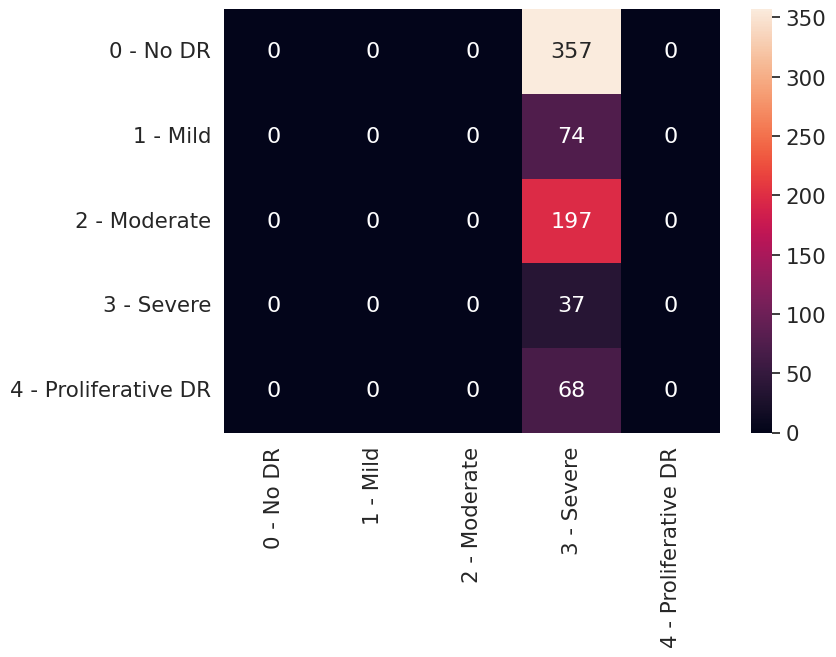

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(train_valid['diagnosis'].astype(int)),test_labels,labels)

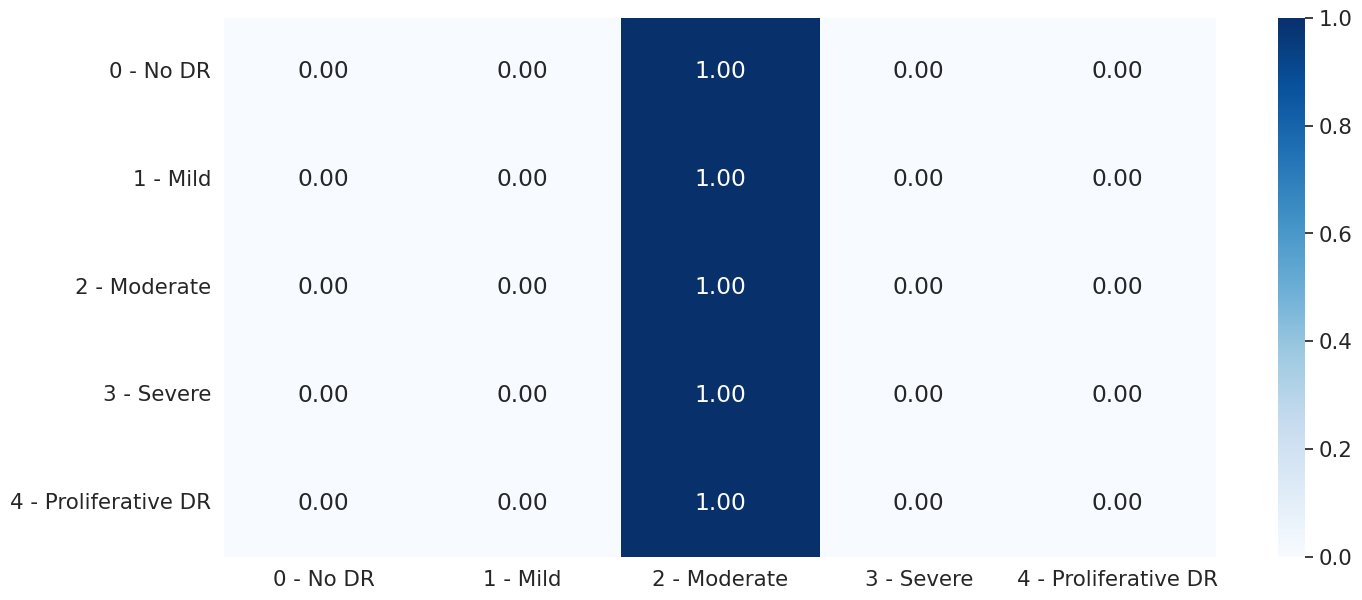

In [ ]:
cnf_matrix = confusion_matrix(train_valid['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()


In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels,train_valid['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(train_valid['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.000
Test Accuracy score : 0.269


In [ ]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.702","0.71"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.79","0.71"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
